In [1]:
!pip install torchview

# 1. Загрузка данных

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
! mkdir simpsons
! unzip the-simpsons-characters-dataset.zip -d simpsons

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1281.jpg  
  inflating: simpso

In [4]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
from torch.utils.data import Dataset
import torch.nn
import numpy as np
import os
import time
import re
from glob import glob
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [5]:
train_dir = Path('/content/simpsons/simpsons_dataset/')
test_dir = Path('/content/simpsons/kaggle_simpson_testset/')

files_training = glob(os.path.join(train_dir,'simpsons_dataset', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

Number of images in Training file: 20933


Классы датасета и количество экземпляров в тренировочной выборке.

In [6]:
im_cnt = []
class_names = []
total = 0
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(train_dir, 'simpsons_dataset')):
    folder_num = len(os.listdir(os.path.join(train_dir,'simpsons_dataset',folder)))
    total += folder_num
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)

num_classes = len(class_names)
print('Total number of classes: {}'.format(num_classes))
print('Total number of objects: {}'.format(total))

class             Count:
------------------------
disco_stu            8
waylon_smithers      181
kent_brockman        498
comic_book_guy       469
gil                  27
chief_wiggum         986
sideshow_bob         877
lionel_hutz          3
apu_nahasapeemapetilon 623
lenny_leonard        310
principal_skinner    1194
lisa_simpson         1354
nelson_muntz         358
edna_krabappel       457
marge_simpson        1291
fat_tony             27
cletus_spuckler      47
bart_simpson         1342
mayor_quimby         246
rainier_wolfcastle   45
charles_montgomery_burns 1193
snake_jailbird       55
troy_mcclure         8
patty_bouvier        72
selma_bouvier        103
abraham_grampa_simpson 913
krusty_the_clown     1206
barney_gumble        106
sideshow_mel         40
maggie_simpson       128
milhouse_van_houten  1079
carl_carlson         98
homer_simpson        2246
ned_flanders         1454
professor_john_frink 65
miss_hoover          17
ralph_wiggum         89
otto_mann            32
a

Создадим датасет для Симпсонов:

In [7]:
class SimpsonsDataset(Dataset):
  def __init__(self, root, train, transform=None):
    self.root = root
    self.train = train
    self.transform = transform
    train_files = sorted(list(
        Path(os.path.join(root, 'simpsons_dataset', 'simpsons_dataset')).rglob('*.jpg')
    ))
    test_files = sorted(list(
        Path(os.path.join(root, 'kaggle_simpson_testset')).rglob('*.jpg')
    ))
    train_labels = [path.parent.name for path in train_files]
    test_labels = [re.sub(r"_\d+.jpg$", "", path.name) for path in test_files]

    self.label_encoder = LabelEncoder()
    self.label_encoder.fit(train_labels)

    if train:
      self.length = len(train_files)
      self.files = train_files
      self.labels = train_labels
    else:
      self.length = len(test_files)
      self.files = test_files
      self.labels = test_labels

  def __len__(self):
    return self.length

  def get_label_encoder(self):
    return self.label_encoder

  def __getitem__(self, index):
    x = Image.open(self.files[index])
    x.load()
    x = self.transform(x)
    label = self.labels[index]
    label_id = self.label_encoder.transform([label])
    y = label_id.item()
    return x, y

In [8]:
dir_name = Path('/content/simpsons/')
norm_params = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
batch_size = 64
size = 140
center_crop = 128

Изменим размер каждой картинки на 140х140, а затем обрежем до 128х128. Размер batch выберем 64.

Выполним предобработку тренировочных данных:
*   изменение размеров изображений;   
*   нормализация данных по каналам;
*   случайный горизонтальный переворот;
*   обрезка изображения в случайном месте с дополнениям по всем границам;


In [9]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size),
        torchvision.transforms.CenterCrop(center_crop),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params, inplace=True)
    ]
)

transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size),
        torchvision.transforms.CenterCrop(center_crop),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params)
    ]
)

In [10]:
train_dataset = SimpsonsDataset(
    root = dir_name, train = True,
    transform = train_transforms
)
test_dataset = SimpsonsDataset(
    root = dir_name, train = False,
    transform = transforms
)

In [11]:
def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denormal(images[i][0], *norm_params)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))

Визуально отобразим несколько примеров из тернировочных и тестовых данных.

Number of train samples: 20933
Number of test samples: 990


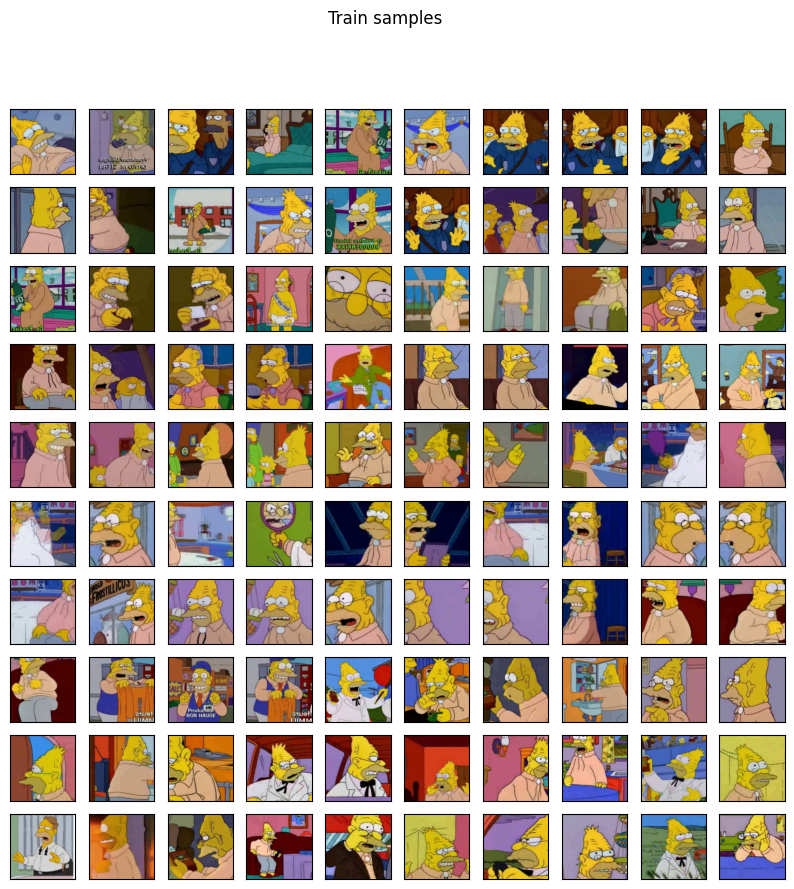

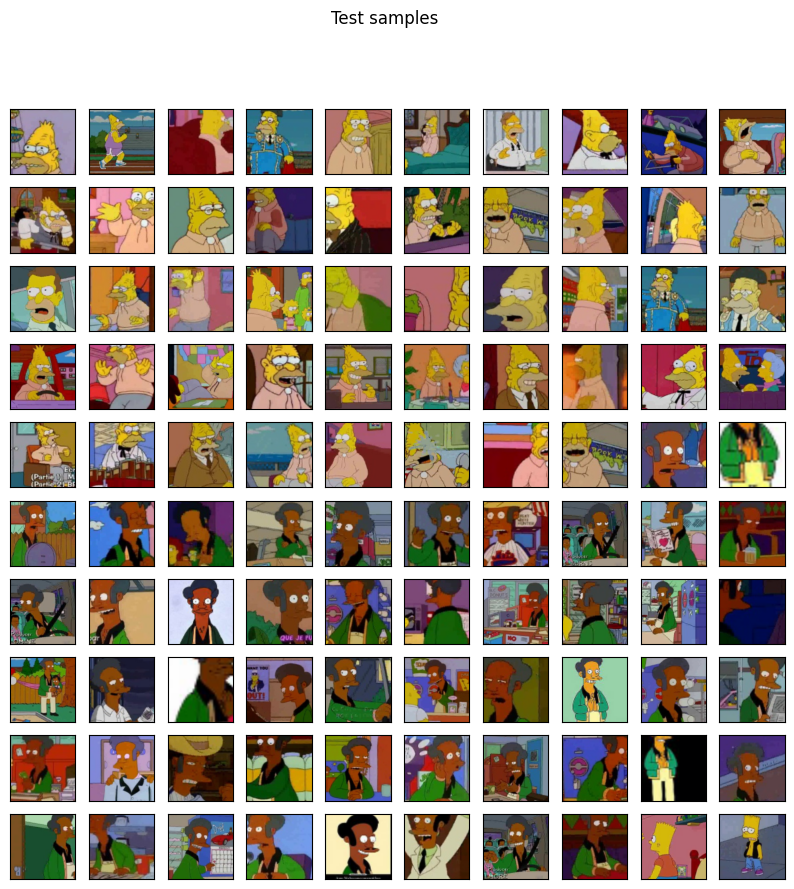

In [12]:
print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

In [13]:
def shape_input(dataset):
  N = len(dataset)
  channels, h, w = dataset[0][0].numpy().shape
  return '({}, {}, {}, {})'.format(N, channels, h, w)

def shape_output(dataset):
  N = len(dataset)
  return '({}, 1)'.format(N)

In [14]:
print('Размерность входных данных тренировочной выборки: {}'.format(shape_input(train_dataset)))
print('Размерность входных данных тестовой выборки: {}'.format(shape_input(test_dataset)))
print()
print('Размерность ответов тренировочной выборки: {}'.format(shape_output(train_dataset)))
print('Размерность ответов тестовой выборки: {}'.format(shape_output(test_dataset)))
print()
print('Тип входных данных {}'.format(train_dataset[0][0].numpy().dtype))

Размерность входных данных тренировочной выборки: (20933, 3, 128, 128)
Размерность входных данных тестовой выборки: (990, 3, 128, 128)

Размерность ответов тренировочной выборки: (20933, 1)
Размерность ответов тестовой выборки: (990, 1)

Тип входных данных float32


Приведем несколько примеров с метками.

In [16]:
def get_label_name(label_encoder, label_id):
  return label_encoder.inverse_transform([label_id]).item()

label_en = train_dataset.get_label_encoder()

def view_image(image, title):
  img = denormal(image[0], *norm_params)
  img = img.numpy().transpose(1, 2, 0)
  figsize = (10, 10)
  plt.title("{}: {}".format(title, get_label_name(label_en, image[1])))
  plt.imshow((img * 255).astype('uint8'))

Label: 15


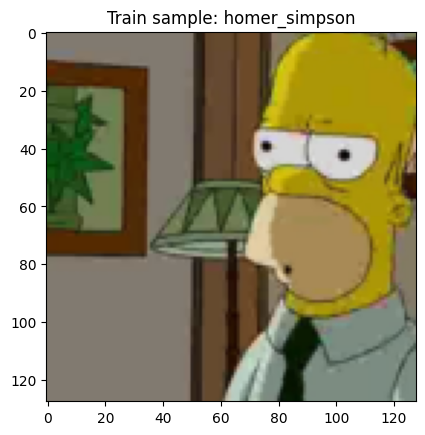

In [17]:
ind = 8008
view_image(train_dataset[ind], 'Train sample')
print('Label: {}'.format(train_dataset[ind][1]))

Label: 9


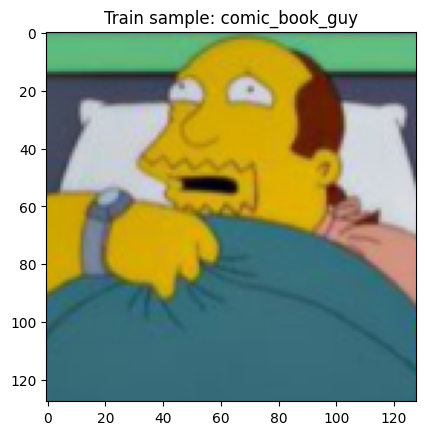

In [18]:
ind = 5378
view_image(train_dataset[ind], 'Train sample')
print('Label: {}'.format(train_dataset[ind][1]))

In [19]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

In [20]:
final_size = center_crop // 32
print(final_size)

4


# 2. Построение архитектуры сверточной сети

Будем строить сверточную нейронную сеть архитектуры ResNet.

In [21]:
def blocks(in_channels, out_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True)
    )

In [22]:
class ResNet9(torch.nn.Module):
  def __init__(self):
      super(ResNet9, self).__init__()
      self.conv1 = blocks(3, 64)
      self.conv_and_pool_1 = torch.nn.Sequential(
          blocks(64, 128),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res1 = torch.nn.Sequential(
          blocks(128, 128),
          blocks(128, 128)
      )
      self.conv_and_pool_2 = torch.nn.Sequential(
          blocks(128, 256),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.conv_and_pool_3 = torch.nn.Sequential(
          blocks(256, 512),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res2 = torch.nn.Sequential(
          blocks(512, 512),
          blocks(512, 512)
      )
      self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
      self.dense = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Dropout(0.2),
          torch.nn.Linear(512 * final_size * final_size, num_classes)
      )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv_and_pool_1(out)
    out = self.res1(out) + out
    out = self.conv_and_pool_2(out)
    out = self.conv_and_pool_3(out)
    out = self.res2(out) + out
    out = self.final_pool(out)
    out = self.dense(out)
    return out

Выведем информацию об архитектуре.

In [23]:
cnn_model = ResNet9()
cnn_model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

Визуализируем сеть.

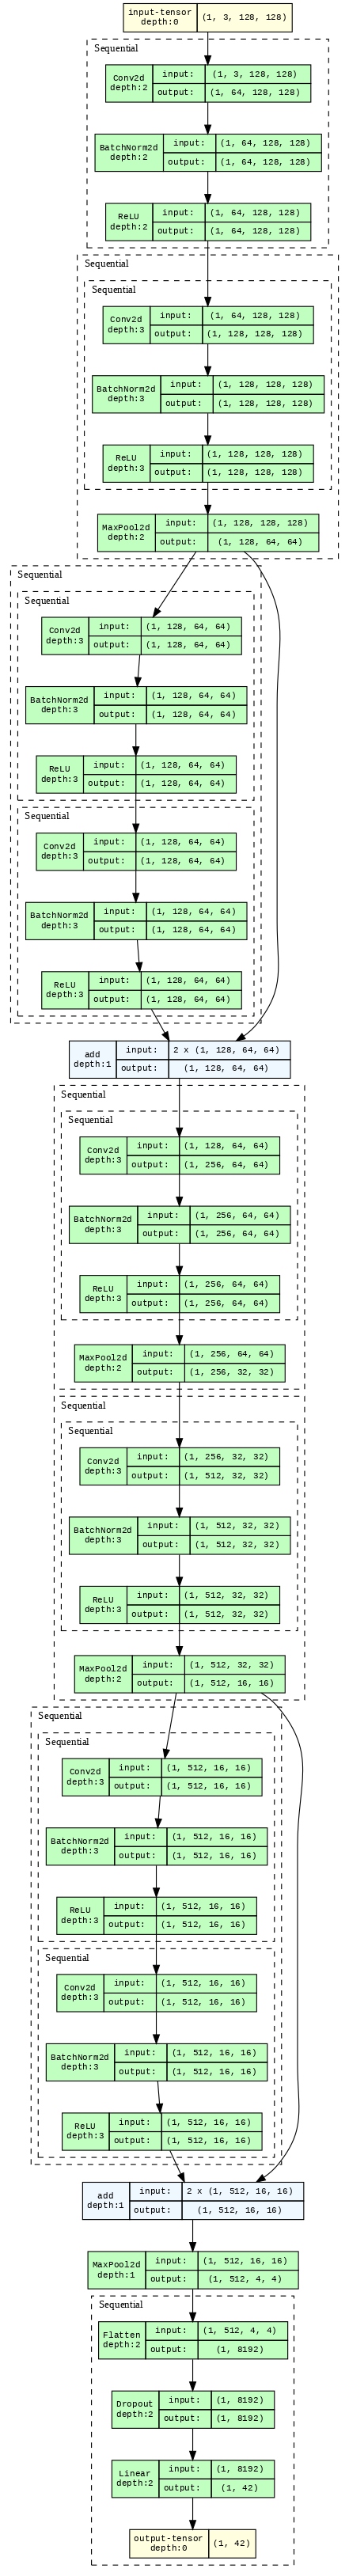

In [24]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(cnn_model, input_size=(1,3,center_crop,center_crop), expand_nested=True)
model_graph.visual_graph

# 3 Обучение модели

In [25]:
learning_rate = 0.001
num_epochs = 25

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)

In [26]:
def get_accuracy(model, data_loader, device):
    falses = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            falses += (predicted != labels).sum()
    return 1 - 2 * falses / (n * num_classes)

def get_f1(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    precision = tp / n
    recall = tp / n
    return 2 * precision * recall / (precision + recall)

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(1 - 2 * torch.sum(predicted != labels).item() / (len(predicted) * num_classes))

def f1_scope(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  precision = torch.sum(predicted == labels).item() / len(predicted)
  recall = torch.sum(predicted == labels).item() / len(predicted)
  f1 = 2 * precision * recall / (precision + recall)
  return torch.tensor(f1)

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_f1(f1s):
  return torch.stack(f1s).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [27]:
def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
  start_time = time.time()
  for epoch in range(epochs):
    start_epoch = time.time()
    accuracies = []
    f1s = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)
        f1 = f1_scope(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)
        f1s.append(f1)

        loss.backward()
        optimizer.step()
    total_time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Loss = {:.4f}, Train accuracy = {:.4f}, Train f1 = {:.4f}, Time epoch = {:.4f}'.
          format(epoch + 1,
                 epoch_loss(losses),
                 epoch_acc(accuracies),
                 epoch_f1(f1s),
                 total_time_epoch))
  total_time = time.time() - start_time
  print('Total time {}'.format(total_time))

In [ ]:
train(cnn_model, train_data_loader, num_epochs, loss_function, optimizer, device)

Epoch[1]: Loss = 3.5100, Train accuracy = 0.9677, Train f1 = 0.3217, Time epoch = 141.8621
Epoch[2]: Loss = 1.4737, Train accuracy = 0.9823, Train f1 = 0.6283, Time epoch = 141.7204
Epoch[3]: Loss = 0.9395, Train accuracy = 0.9878, Train f1 = 0.7429, Time epoch = 141.4985
Epoch[4]: Loss = 0.7148, Train accuracy = 0.9907, Train f1 = 0.8044, Time epoch = 141.8602
Epoch[5]: Loss = 0.5673, Train accuracy = 0.9924, Train f1 = 0.8406, Time epoch = 141.5829
Epoch[6]: Loss = 0.4728, Train accuracy = 0.9939, Train f1 = 0.8715, Time epoch = 141.5781
Epoch[7]: Loss = 0.4632, Train accuracy = 0.9939, Train f1 = 0.8709, Time epoch = 141.3336
Epoch[8]: Loss = 0.3575, Train accuracy = 0.9954, Train f1 = 0.9034, Time epoch = 141.2878
Epoch[9]: Loss = 0.3040, Train accuracy = 0.9959, Train f1 = 0.9148, Time epoch = 141.1801
Epoch[10]: Loss = 0.2373, Train accuracy = 0.9969, Train f1 = 0.9340, Time epoch = 141.3664
Epoch[11]: Loss = 0.2111, Train accuracy = 0.9972, Train f1 = 0.9417, Time epoch = 141.89

# 4. Тестирование модели

In [ ]:
print('Loss = {:.4f}, Test accuracy = {:.4f}, Test f1 = {:.4f}'.format(
    get_loss(cnn_model, test_data_loader, device),
    get_accuracy(cnn_model, test_data_loader, device),
    get_f1(cnn_model, test_data_loader, device)))

Loss = 0.0138, Test accuracy = 0.9909, Test f1 = 0.8152


# Приложение
Код для сохранения и загрузки модели.

In [ ]:
torch.save(cnn_model.state_dict(), 'cnnModel.pth')
cnn_model.load_state_dict(torch.load('cnnModel.pth'))

<All keys matched successfully>

In [ ]:
cnn_model.load_state_dict(torch.load('cnnModel.pth', map_location=torch.device('cpu')))